# Learn VoC
### Sierra Methodology

In [1]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

In [2]:
batterySet = pickle.load(open("./Battery_Data/new_battery_cycles/new_battery_v2.p", 'rb'))

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

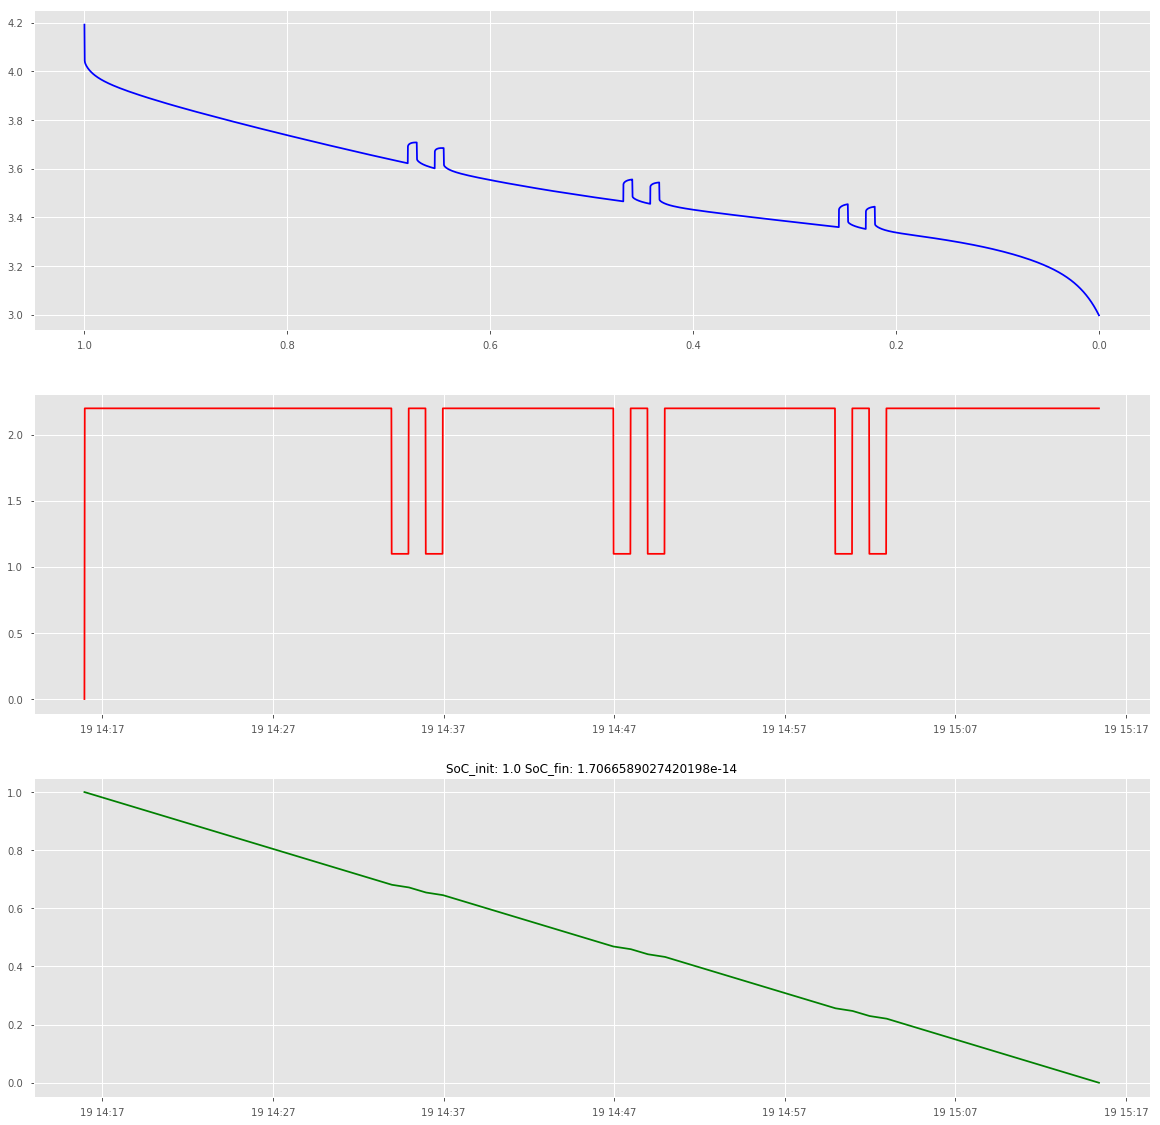

In [4]:
charSet = batterySet[1]
current = np.array(charSet['Current'], ndmin=2)*-1.0
seconds = np.ones_like(current)
C_n = np.sum(current*seconds)
SoC = []
SoC_state = 1.0
SoC_init = SoC_state
for i in range(current.shape[1]):
    SoC_state -= current[0, i]/C_n
    SoC.append(SoC_state)

Characterisation_Set = {}
Characterisation_Set['C_n'] = C_n
Characterisation_Set['SoC'] = np.array(SoC, ndmin=2)
Characterisation_Set['Current'] = current
Characterisation_Set['Voltage'] = charSet['Voltage']

matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
plt.figure("SoC Estimate")
plt.subplot(311)
plt.plot(SoC, charSet['Voltage'].T, '-b')
plt.gca().invert_xaxis()
plt.subplot(312)
plt.plot(charSet['datetime'].T, current.T, '-r')
plt.subplot(313)
plt.title("SoC_init: {0} SoC_fin: {1}".format(SoC_init, SoC[-1]))
plt.plot(charSet['datetime'].T, np.array(SoC), '-g')

## Define VoC
$|Z_p | = |\Delta V / \Delta I|$, assuming $v oc ( k ) = v ( k ) + i ( k )· Z_p$

In [5]:
high_low_index = []
low_high_index = []
for i in range(1, current.shape[1] - 1):
    if current[0, i] - current[0, i + 1] > 0.001:
        print("High -> Low", current[0, i], current[0, i+1])
        high_low_index.append(i)
    elif current[0, i + 1] - current[0, i] > 0.001:
        print("Low -> High", current[0, i], current[0, i+1])
        low_high_index.append(i)

High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09794 2.19783
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19783 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784


In [6]:
delta_V = np.abs(charSet['Voltage'][0, high_low_index]-charSet['Voltage'][0, low_high_index])
delta_I = np.abs(current[0, high_low_index]-current[0, low_high_index])
delta_Z = delta_V/delta_I
Z_p = np.mean(delta_Z)
print(Z_p)
print(high_low_index)
print(low_high_index)

0.08076263685971334
[1080, 1200, 1860, 1980, 2640, 2760]
[1140, 1260, 1920, 2040, 2700, 2820]


## Zone 2



In [7]:
SoC = np.array(SoC, ndmin=2)
voltage = charSet['Voltage']

(1, 2846)
(1, 2846) <class 'numpy.ndarray'>


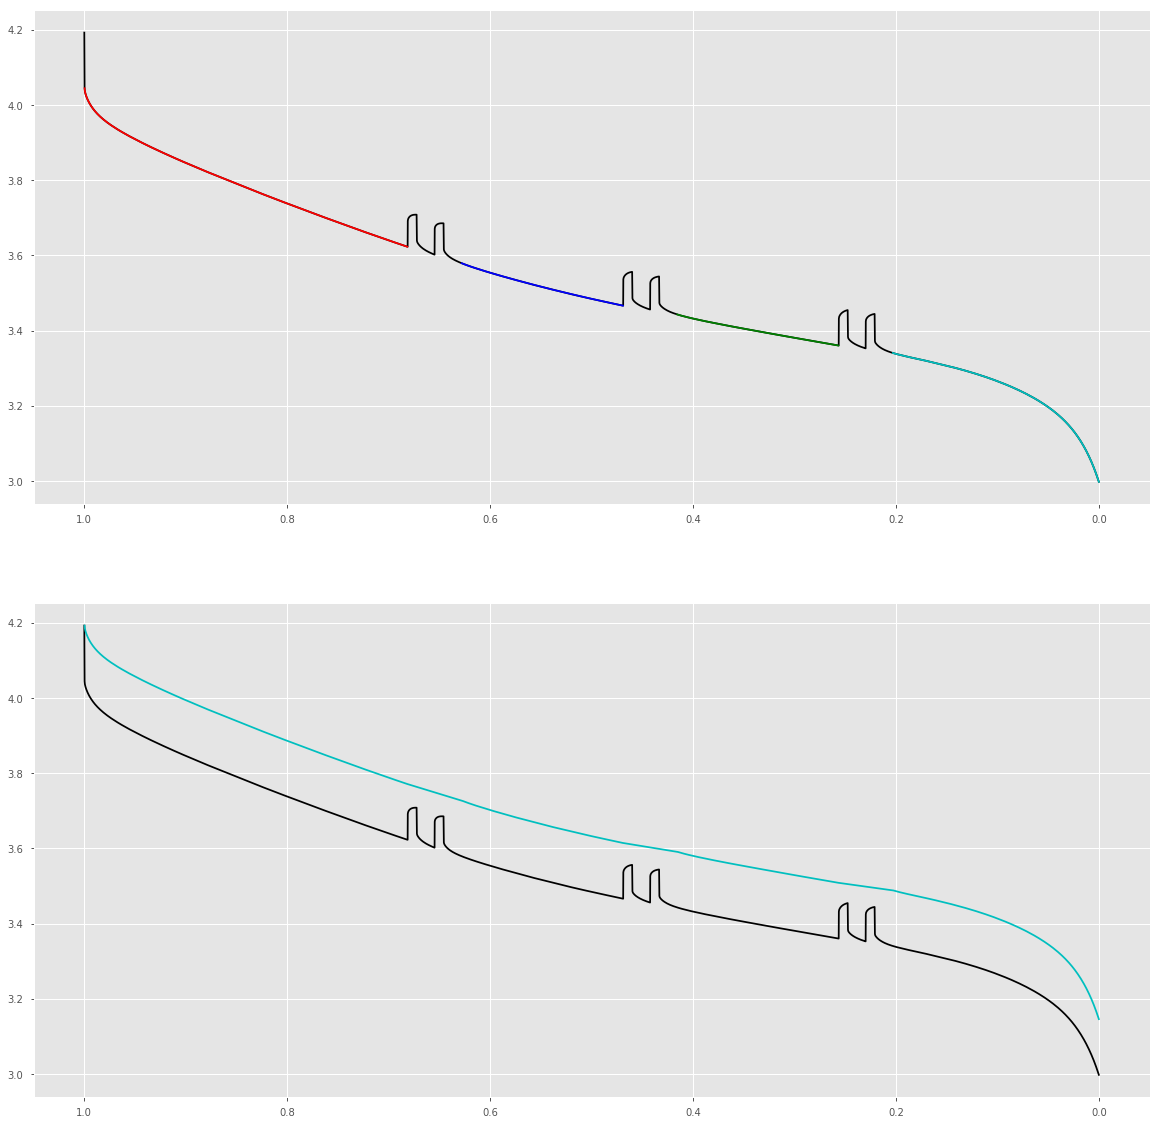

In [8]:
delta_t = low_high_index[0] + 1 - high_low_index[0]

l1_soc = SoC[0, 1:high_low_index[0]]
l1_v = voltage[0, 1:high_low_index[0]]

l2_soc = SoC[0, low_high_index[1]+delta_t:high_low_index[2]]
l2_v = voltage[0, low_high_index[1]+delta_t:high_low_index[2]]

l3_soc = SoC[0, low_high_index[3]+delta_t:high_low_index[4]]
l3_v = voltage[0, low_high_index[3]+delta_t:high_low_index[4]]

l4_soc = SoC[0, low_high_index[5]+delta_t:]
l4_v = voltage[0, low_high_index[5]+delta_t:]

SoC_smoothed = np.array(np.concatenate((l1_soc, l2_soc, l3_soc, l4_soc)), ndmin=2)
print(SoC_smoothed.shape)
V_smoothed = np.array(np.concatenate((l1_v, l2_v, l3_v, l4_v), axis=1), ndmin=2)
print(V_smoothed.shape, type(V_smoothed))

voc_gt = V_smoothed + voltage[0,0] - voltage[0, 1]

plt.subplot(211)
plt.plot(SoC.T, voltage.T, '-k')
plt.plot(l1_soc.T, l1_v.T, '-r')
plt.plot(l2_soc.T, l2_v.T, '-b')
plt.plot(l3_soc.T, l3_v.T, '-g')
plt.plot(l4_soc.T, l4_v.T, '-c')
plt.gca().invert_xaxis()
plt.subplot(212)
plt.plot(SoC.T, voltage.T, '-k')
plt.plot(SoC_smoothed.T, voc_gt.T, '-c')
plt.gca().invert_xaxis()


### Robust Regression for the Sierra Model
$$ v_{OC}(k) = v_L + \alpha\cdot e^{\gamma\cdot SoC(k)} - \mu\cdot e^{-\beta\sqrt{SoC(k)}}$$

In [9]:
def VoC(SoC, v_L, mu, gamma, alpha, beta):
    return v_L + alpha*np.exp(gamma*SoC) - mu*np.exp(-beta*np.sqrt(SoC))

In [10]:
from scipy.optimize import curve_fit

In [11]:
popt, pcov = curve_fit(VoC, SoC_smoothed[0, :], voc_gt[0, :])

In [12]:
popt

array([3.37504902, 0.41208709, 2.05546383, 0.0985182 , 4.95368069])

In [13]:
pcov

array([[ 8.28221656e-06,  1.21882499e-06,  3.22306078e-05,
        -4.09134563e-06, -1.31289970e-04],
       [ 1.21882499e-06,  2.12848999e-06,  5.85754996e-06,
        -7.11313986e-07,  4.18620609e-06],
       [ 3.22306078e-05,  5.85754996e-06,  1.31792637e-04,
        -1.64760704e-05, -4.70671532e-04],
       [-4.09134563e-06, -7.11313986e-07, -1.64760704e-05,
         2.07043983e-06,  6.11203254e-05],
       [-1.31289970e-04,  4.18620609e-06, -4.70671532e-04,
         6.11203254e-05,  2.56126269e-03]])

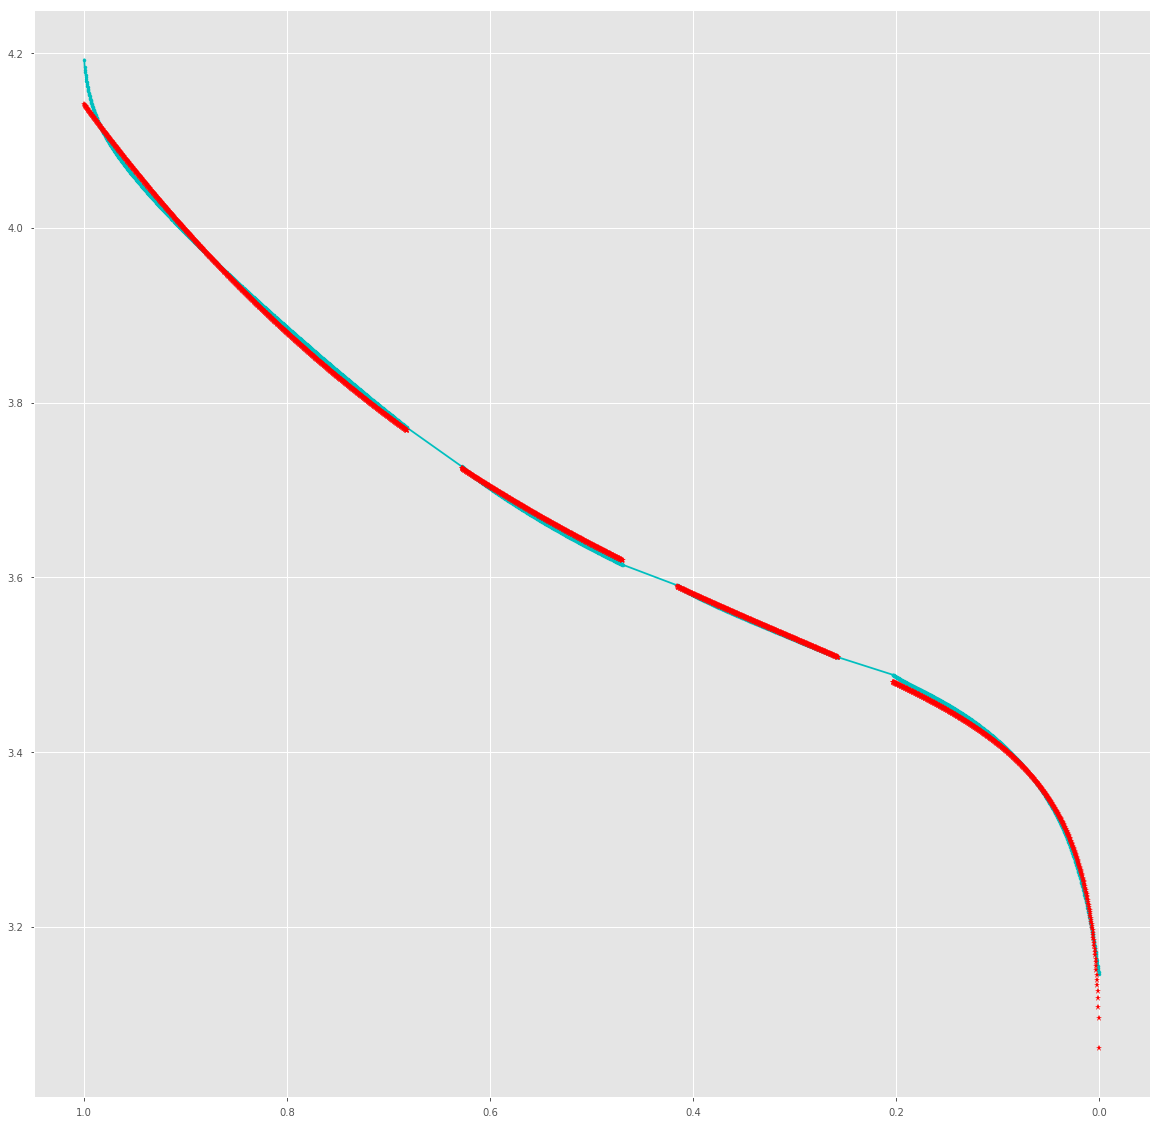

In [14]:
plt.plot(SoC_smoothed[0, :], voc_gt[0, :], '.-c')
plt.plot(SoC_smoothed[0, :], VoC(SoC_smoothed[0, :], *popt), '*r')

plt.gca().invert_xaxis()

In [15]:
def func(SoC, a,b,c,d,e,f,g):
    return a + b*SoC + c*np.power(SoC,2) + d*np.power(SoC,3) \
            + e*np.power(SoC,4) + f*np.power(SoC,5) + g*np.power(SoC,6)

In [16]:
popt, pcov = curve_fit(func, SoC_smoothed[0, :], voc_gt[0, :])

In [17]:
popt

array([  3.195866  ,   3.42546244, -16.07904217,  40.70036539,
       -51.97041131,  33.04057365,  -8.17009692])

In [19]:
pcov

array([[ 6.24298515e-07, -1.50092757e-05,  1.12594498e-04,
        -3.75182708e-04,  6.18646183e-04, -4.94535243e-04,
         1.52950806e-04],
       [-1.50092757e-05,  4.85611608e-04, -4.14494856e-03,
         1.48525044e-02, -2.56583437e-02,  2.11855642e-02,
        -6.70988887e-03],
       [ 1.12594498e-04, -4.14494856e-03,  3.82095680e-02,
        -1.43695351e-01,  2.56529576e-01, -2.16888466e-01,
         6.99301673e-02],
       [-3.75182708e-04,  1.48525044e-02, -1.43695351e-01,
         5.58153129e-01, -1.01963753e+00,  8.77035043e-01,
        -2.86574127e-01],
       [ 6.18646183e-04, -2.56583437e-02,  2.56529576e-01,
        -1.01963753e+00,  1.89466298e+00, -1.65119063e+00,
         5.45178401e-01],
       [-4.94535243e-04,  2.11855642e-02, -2.16888466e-01,
         8.77035043e-01, -1.65119063e+00,  1.45396737e+00,
        -4.84098852e-01],
       [ 1.52950806e-04, -6.70988887e-03,  6.99301673e-02,
        -2.86574127e-01,  5.45178401e-01, -4.84098852e-01,
         1.6229622

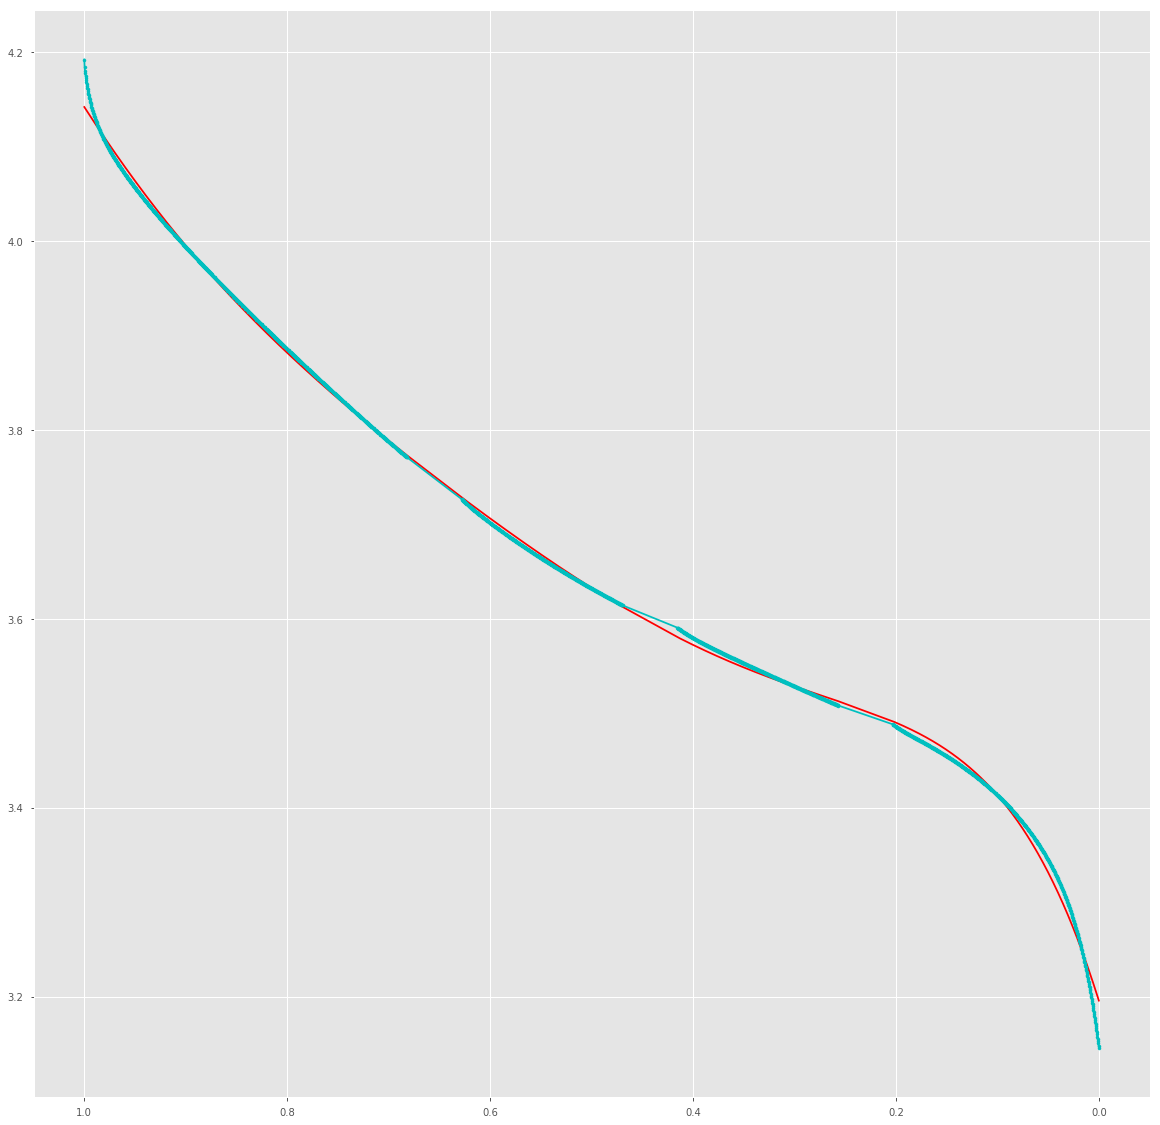

In [18]:
plt.plot(SoC_smoothed[0, :], func(SoC_smoothed[0, :], *popt), '-r')
plt.plot(SoC_smoothed[0, :], voc_gt[0, :], '.-c')

plt.gca().invert_xaxis()